**SOLVE MODEL from GLOBAL YAML FILES**

This is the notebook for running multiple yaml files to get objective values and modelled outputs.

**NEED TO WORK ON SCENARIO 4 NOW!!!!!**

In [ ]:
#pip install tz-osemosys 
#pip install highspy
#import inspect
# import tz.osemosys.model as model_package

# # List all submodules and subpackages in tz.osemosys.model
# list_submodules(tz.osemosys.model)

# # Function to list all classes and functions in a module
# def list_classes_and_functions(module):
#     for name, obj in inspect.getmembers(module):
#         if inspect.isclass(obj) or inspect.isfunction(obj):
#             print(f"{'Class' if inspect.isclass(obj) else 'Function'}: {name}")

# # List all classes and functions in each submodule of tz.osemosys.model
# for importer, modname, ispkg in pkgutil.walk_packages(model_package.__path__, model_package.__name__ + "."):
#     module = __import__(modname, fromlist="dummy")
#     print(f"\nListing for {modname}:\n")
#     list_classes_and_functions(module)

In [ ]:
# from typing import Any
# from pydantic import ConfigDict, Field, conlist, field_serializer, model_validator
# from tz.osemosys.defaults import defaults
# from tz.osemosys.schemas.base import OSeMOSYSBase, OSeMOSYSData, cast_osemosysdata_value
# from tz.osemosys.schemas.compat.technology import OtooleTechnology
# from tz.osemosys.schemas.validation.validation_utils import check_min_vals_lower_max


In [ ]:
from tz.osemosys import Model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

**MUST RUN AFTER CHANGES!**

In [ ]:
# my_model = Model.from_yaml("config/japan")
# my_model.solve(log_fn="solver.log") #that way it will show the expanded results in a logb containing iteration histories

**Run, Solve and Display Model Results**

In [ ]:
demand_scenarios = ['low', 'medium','high']
emissions_scenarios = ['lc', 'nz', 'nz-scope3']

result_summary = pd.DataFrame(columns=['Demand Scenario', 'Emissions Scenario', 'Total Discounted Cost', 'CO2 Emissions'])
plot_df_summary = pd.DataFrame()
scrap_df_summary = pd.DataFrame()

# Loop through each combination of demand and emissions scenarios   

for each_demand_scenario in demand_scenarios:
    for each_emissions_scenario in emissions_scenarios:

        demand_scenario = each_demand_scenario
        emissions_scenario = each_emissions_scenario
        #my_model = Model.from_yaml("config/japan/low-nz-scope3")
        my_model = Model.from_yaml("config/japan/"+demand_scenario+'-'+emissions_scenario)
        my_model.solve(log_fn="solver.log") #that way it will show the expanded results in a logb containing iteration histories
        #my_model.solve()
        tdc = my_model.solution.TotalDiscountedCost.to_dataframe().sum().sum()
        co2 = my_model.solution.AnnualTechnologyEmission.to_dataframe().sum().sum() 
        
        capacity = my_model.solution.NewCapacity.to_dataframe().groupby(['TECHNOLOGY']).sum()
        capacity = capacity.loc[['BFBOF', 'DRI', 'EAF_primary', 'EAF_secondary']].reset_index()

        incentives = {'BFBOF': 0,
                      'DRI': 56,
                      'EAF_primary': 39,
                      'EAF_secondary': 39}
        capacity['POLICYCOST'] = capacity['TECHNOLOGY'].map(incentives) * capacity['NewCapacity']
        tdc_with_policy = tdc + capacity['POLICYCOST'].sum()
        
        result_summary_temp = pd.DataFrame({'Demand Scenario': [demand_scenario],
                                            'Emissions Scenario': [emissions_scenario], 
                                            'Total Discounted Cost': [tdc],
                                            'Total Discounted Cost with Policy': [tdc_with_policy], 
                                            'CO2 Emissions': [co2]})
        result_summary = pd.concat([result_summary, result_summary_temp], 
                                         ignore_index=True)
        
        

        print(f"Total Discounted Cost for {demand_scenario} demand and {emissions_scenario} emissions scenario: {tdc} & {co2.sum()}")
        
        results = my_model.solution

        # Convert TotalAnnualTechnologyActivityByMode to DataFrame and reset index
        activity_df = results['TotalAnnualTechnologyActivityByMode'].to_dataframe().reset_index()

        # Correct mappings of technologies to their modes of operation
        technology_mode_map = {
            'BFBOF': ["BFBOF_MODE1", "BFBOF_MODE2", "BFBOF_MODE3", "BFBOF_MODE4", "BFBOF_MODE5"],
            'DRI': ["DRI_MODE1", "DRI_MODE2", "DRI_MODE3"],
            'EAF_primary': ["EAF_primary_MODE1", "EAF_primary_MODE2"],
            'EAF_secondary': ["EAF_secondary_MODE1"],
            'BACKSTOP_PRIMARY': ["BACKSTOP_PRIMARY_MODE1"],
            'BACKSTOP_SECONDARY': ["BACKSTOP_SECONDARY_MODE1"]
        }

        # Mode descriptions
        mode_descriptions = {
            "BFBOF_MODE1": "Coke",
            "BFBOF_MODE2": "Coke_Scrap",
            "BFBOF_MODE3": "Coke_GreenH2",
            "BFBOF_MODE4": "Coke_GreenH2++",
            "BFBOF_MODE5": "Coke_HBI",
            "DRI_MODE1": "Gas",
            "DRI_MODE2": "Gas_GreenH2(50%)",
            "DRI_MODE3": "GreenH2",
            "EAF_primary_MODE1": "HBI_feed",
            "EAF_primary_MODE2": "HBI-NG_feed",
            "EAF_secondary_MODE1": "Scrap_feed",
            "BACKSTOP_PRIMARY_MODE1": "Backstop Primary", 
            "BACKSTOP_SECONDARY_MODE1": "Backstop Secondary"
        }

        plot_years = [2025, 2030, 2035, 2040, 2045, 2050]

        # Filter the DataFrame to include only valid technology-mode combinations
        filtered_rows = []
        for tech, modes in technology_mode_map.items():
            filtered_rows.append(activity_df[(activity_df['TECHNOLOGY'] == tech) & (activity_df['MODE_OF_OPERATION'].isin(modes))])

        filtered_activity_df = pd.concat(filtered_rows)

        # Replace mode codes with descriptions
        filtered_activity_df['MODE_OF_OPERATION'] = filtered_activity_df['MODE_OF_OPERATION'].map(mode_descriptions)

        # Group by YEAR, TECHNOLOGY, MODE_OF_OPERATION and sum the values
        grouped_activity_df = filtered_activity_df.groupby(['YEAR', 'TECHNOLOGY', 'MODE_OF_OPERATION']).sum().reset_index()

        # Convert values to Mt (megatonnes) by dividing by 1e6
        grouped_activity_df['TotalAnnualTechnologyActivityByMode'] = grouped_activity_df['TotalAnnualTechnologyActivityByMode'] / 1e6
        grouped_activity_df = grouped_activity_df.loc[grouped_activity_df['YEAR'].isin(plot_years)]

        # Pivot the data for plotting
        pivot_activity_df = grouped_activity_df.pivot(index="YEAR", columns=["TECHNOLOGY", "MODE_OF_OPERATION"], values="TotalAnnualTechnologyActivityByMode")

        # Ensure all values are numeric and fill NaN with 0
        pivot_activity_df = pivot_activity_df.apply(pd.to_numeric, errors='coerce').fillna(0)
        
        # Create a new DataFrame for plotting
        plot_df = pivot_activity_df.unstack().reset_index() 
        plot_df['PLOT_COLUMN'] = plot_df['TECHNOLOGY'] + ' [' + plot_df['MODE_OF_OPERATION'] + ']'
        plot_df = plot_df[~plot_df['TECHNOLOGY'].str.startswith('BACKSTOP')]
        plot_df.drop(columns=['TECHNOLOGY', 'MODE_OF_OPERATION'], inplace=True)
        plot_df = plot_df.rename(columns={0: 'VALUE'})
                
        plot_df = plot_df.pivot_table(index=['YEAR'], columns=['PLOT_COLUMN'], values='VALUE', aggfunc='sum').fillna(0).reset_index()
        plot_df['DEMAND_SCENARIO'] = each_demand_scenario
        plot_df['EMISSIONS_SCENARIO'] = each_emissions_scenario
                
        # Append the plot DataFrame to the summary DataFrame
        plot_df_summary = pd.concat([plot_df_summary, plot_df], ignore_index=True)
        # plot_df.to_csv("pivot_activity_df.csv", index=False)
        
        
        scrap_df = my_model.solution.ProductionByTechnology.to_dataframe().groupby(['TECHNOLOGY', 'YEAR']).sum().reset_index().query("TECHNOLOGY in ['SCRAPSUPPLY']")
        scrap_df['DEMAND_SCENARIO'] = each_demand_scenario
        scrap_df['EMISSIONS_SCENARIO'] = each_emissions_scenario
        scrap_df_summary = pd.concat([scrap_df_summary, scrap_df], ignore_index=True)
        
print(result_summary)

Writing integer variables.: 100%|██████████| 1/1 [00:00<00:00, 465.78it/s]
/var/folders/5w/6cly89qs6hxfqs39wgpz_53h0000gn/T/ipykernel_73497/3056087717.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_summary = pd.concat([result_summary, result_summary_temp],


Total Discounted Cost for low demand and lc emissions scenario: 21361009628914.68 & 2432871499.77


Writing integer variables.: 100%|██████████| 1/1 [00:00<00:00, 495.78it/s]


Total Discounted Cost for low demand and nz emissions scenario: 21362412658453.19 & 2248802114.811


Writing integer variables.: 100%|██████████| 1/1 [00:00<00:00, 575.43it/s]


Total Discounted Cost for low demand and nz-scope3 emissions scenario: 21363939793750.38 & 2296320566.9849997


Writing integer variables.: 100%|██████████| 1/1 [00:00<00:00, 557.16it/s]


Total Discounted Cost for medium demand and lc emissions scenario: 62569795185528.375 & 3002241172.2799997


Writing integer variables.: 100%|██████████| 1/1 [00:00<00:00, 596.29it/s]


Total Discounted Cost for medium demand and nz emissions scenario: 62573473002781.195 & 2455185595.1000004


Writing integer variables.: 100%|██████████| 1/1 [00:00<00:00, 419.98it/s]


Total Discounted Cost for medium demand and nz-scope3 emissions scenario: 62595448867065.91 & 2595524372.05


Writing integer variables.: 100%|██████████| 1/1 [00:00<00:00, 628.93it/s]


Total Discounted Cost for high demand and lc emissions scenario: 133671339098386.94 & 3199860189.9600005


Writing integer variables.: 100%|██████████| 1/1 [00:00<00:00, 425.90it/s]


Total Discounted Cost for high demand and nz emissions scenario: 133676502104737.8 & 2499052399.68


Writing integer variables.: 100%|██████████| 1/1 [00:00<00:00, 520.84it/s]


Total Discounted Cost for high demand and nz-scope3 emissions scenario: 133713962879109.81 & 2634632618.4560003
  Demand Scenario Emissions Scenario  Total Discounted Cost  CO2 Emissions  \
0             low                 lc           2.136101e+13   2.432871e+09   
1             low                 nz           2.136241e+13   2.248802e+09   
2             low          nz-scope3           2.136394e+13   2.296321e+09   
3          medium                 lc           6.256980e+13   3.002241e+09   
4          medium                 nz           6.257347e+13   2.455186e+09   
5          medium          nz-scope3           6.259545e+13   2.595524e+09   
6            high                 lc           1.336713e+14   3.199860e+09   
7            high                 nz           1.336765e+14   2.499052e+09   
8            high          nz-scope3           1.337140e+14   2.634633e+09   

   Total Discounted Cost with Policy  
0                       2.136149e+13  
1                       2.136

In [ ]:
scrap_df_summary

,TECHNOLOGY,YEAR,ProductionByTechnology
0,SCRAPSUPPLY,2022,39786600.0
1,SCRAPSUPPLY,2023,39259000.0
2,SCRAPSUPPLY,2024,39051700.0
3,SCRAPSUPPLY,2025,38819000.0
4,SCRAPSUPPLY,2026,38598900.0
...,...,...,...
346,SCRAPSUPPLY,2056,36721100.0
347,SCRAPSUPPLY,2057,33574000.0
348,SCRAPSUPPLY,2058,33559600.0
349,SCRAPSUPPLY,2059,33545300.0


In [ ]:
result_summary.to_csv('result_summary.csv', index=False)
plot_df_summary.to_csv('plot_df_summary.csv', index=False)

In [ ]:
#CHECK dimensions here
#print(dir(my_model))
#See variables
#my_model.solution
## To export a variable into excel 
# Run the model

demand_scenario = 'high'
emissions_scenario = 'nz-scope3'
#my_model = Model.from_yaml("config/japan/low-nz-scope3")
my_model = Model.from_yaml("config/japan/"+demand_scenario+'-'+emissions_scenario)
my_model.solve(log_fn="solver.log") #that way it will show the expanded results in a logb containing iteration histories
#my_model.solve()
my_model.solution.TotalDiscountedCost.to_dataframe().to_csv("TDC.csv")
my_model.solution.marginal_cost_of_emissions_annual.to_dataframe().to_csv("carbonprice.csv")
my_model.solution.AnnualTechnologyEmission.to_dataframe().to_csv("emissionsbytech.csv")


Writing integer variables.: 100%|██████████| 1/1 [00:00<00:00, 617.72it/s]


     YEAR DEMAND_SCENARIO EMISSIONS_SCENARIO                PLOT_COLUMN  \
0    2025             low                 lc                BFBOF[Coke]   
1    2030             low                 lc                BFBOF[Coke]   
2    2035             low                 lc                BFBOF[Coke]   
3    2040             low                 lc                BFBOF[Coke]   
4    2045             low                 lc                BFBOF[Coke]   
..    ...             ...                ...                        ...   
589  2030            high          nz-scope3  EAF_secondary[Scrap_feed]   
590  2035            high          nz-scope3  EAF_secondary[Scrap_feed]   
591  2040            high          nz-scope3  EAF_secondary[Scrap_feed]   
592  2045            high          nz-scope3  EAF_secondary[Scrap_feed]   
593  2050            high          nz-scope3  EAF_secondary[Scrap_feed]   

       VALUE  
0    60.2580  
1    52.2280  
2     0.0000  
3     0.0000  
4     0.0000  
..       

/Users/adminuser/miniforge3/envs/ecf-steel-env/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/adminuser/miniforge3/envs/ecf-steel-env/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/adminuser/miniforge3/envs/ecf-steel-env/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/adminuser/miniforge3/envs/ecf-steel-env/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/adminuser/miniforge3/envs/ecf-steel-env/lib/python3.12/site-packages/seaborn

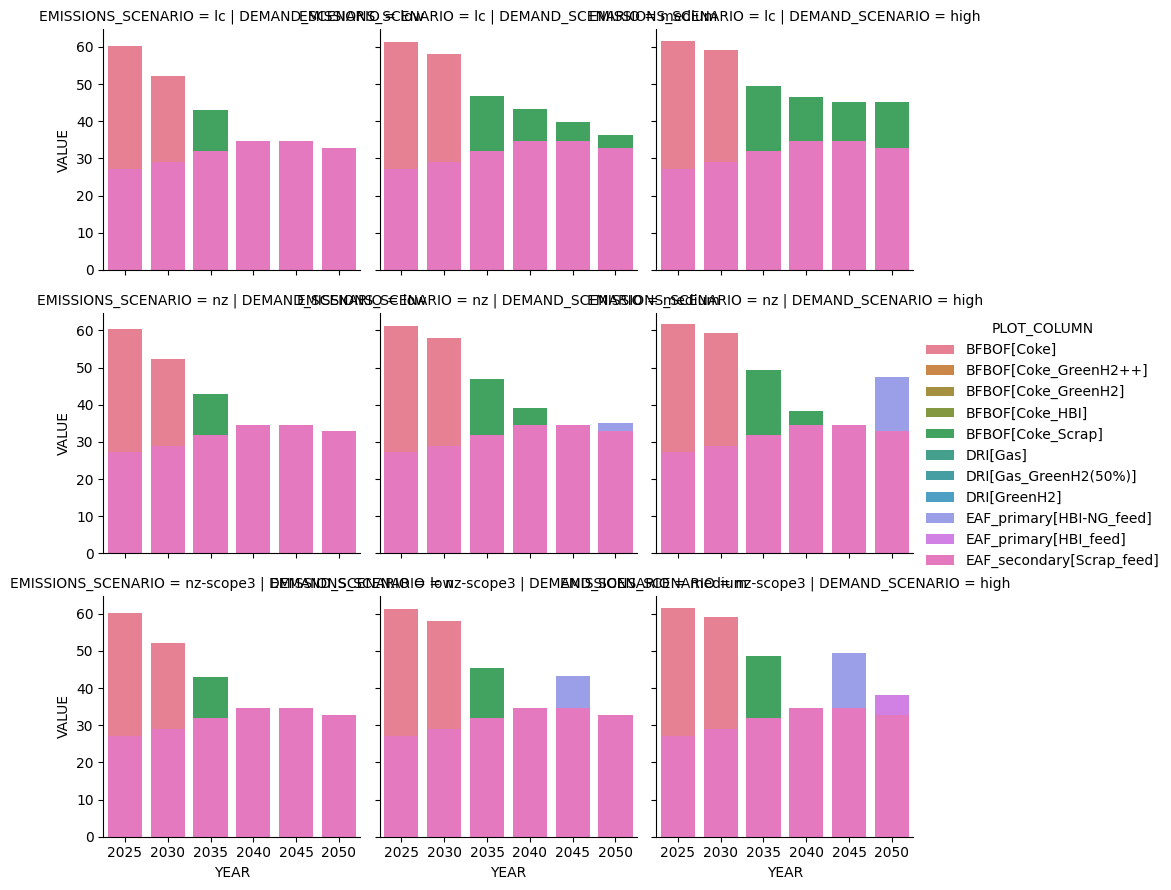

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
plot_df_summary = pd.read_csv('plot_df_summary.csv')

# Melt the dataframe to make it suitable for facetting
melted_df = plot_df_summary.melt(
    id_vars=['YEAR', 'DEMAND_SCENARIO', 'EMISSIONS_SCENARIO'],
    var_name='PLOT_COLUMN',
    value_name='VALUE'
)
print(melted_df)
g = sns.FacetGrid(melted_df, 
                  col = 'DEMAND_SCENARIO',  
                  row = 'EMISSIONS_SCENARIO', 
                  hue = 'PLOT_COLUMN'
                  )
g = (g.map(sns.barplot, 
           'YEAR', 
           'VALUE', 
           ci = None).add_legend())

plt.show()



**Mix by
 Mode of Operation**

In [ ]:
my_model.solution.AnnualTechnologyEmission.to_dataframe().sum().sum()

2634632618.4560003

In [ ]:
my_model.solution.TotalDiscountedCost.to_dataframe().sum().sum()

133713962879109.81

In [ ]:
print(10311000.0*39)

402129000.0


In [ ]:
capacity = my_model.solution.NewCapacity.to_dataframe().groupby(['TECHNOLOGY']).sum()
capacity = capacity.loc[['BFBOF', 'DRI', 'EAF_primary', 'EAF_secondary']].reset_index()

incentives = {'BFBOF': 0,
             'DRI': 56,
             'EAF_primary': 39,
             'EAF_secondary': 39}
capacity['POLICYCOST'] = capacity['TECHNOLOGY'].map(incentives) * capacity['NewCapacity']
print(capacity['POLICYCOST'].sum())


4506032417.0


<Figure size 1920x1440 with 0 Axes>

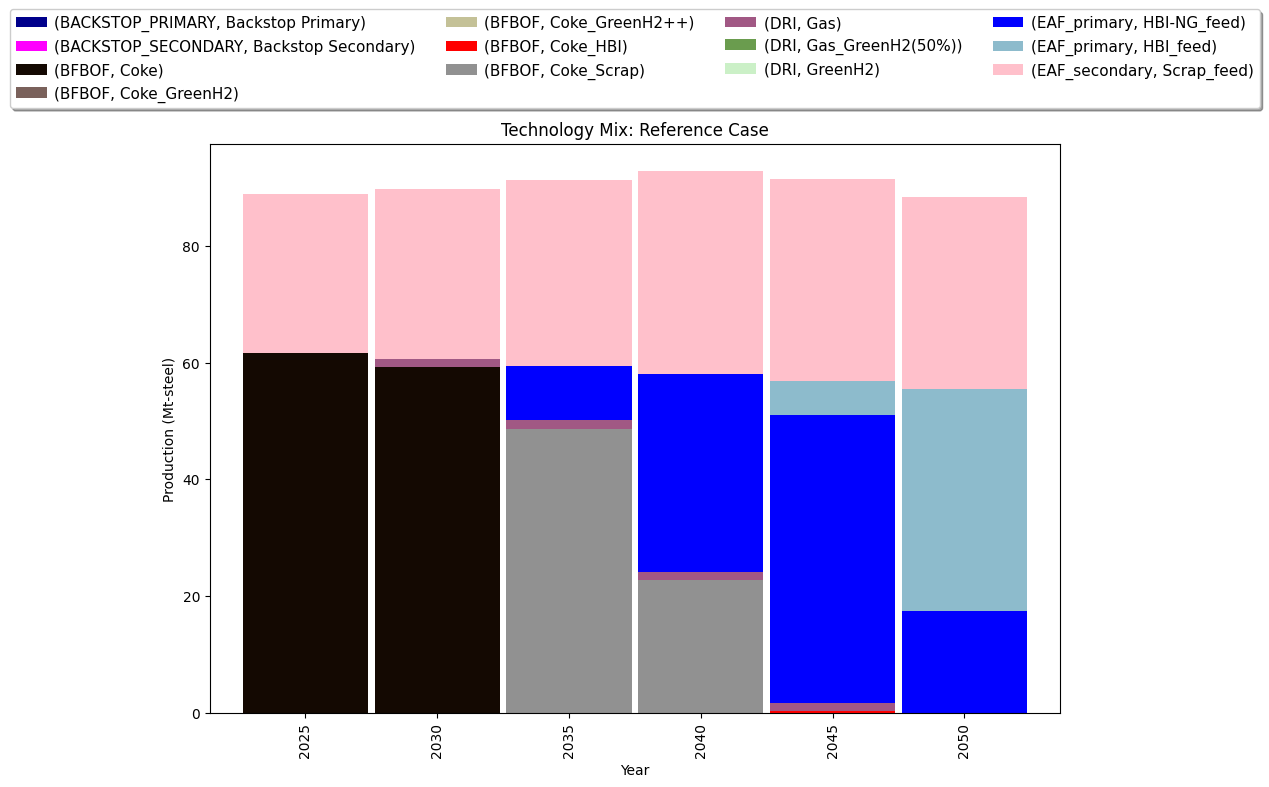

In [ ]:
# import pandas as pd
import matplotlib.pyplot as plt
# from tz.osemosys import Model

import seaborn as sns
# Load the model and solve it
# my_model = Model.from_yaml("config/japan")
# my_model.solve(log_fn="solver.log")

# Extract results
results = my_model.solution

# Convert TotalAnnualTechnologyActivityByMode to DataFrame and reset index
activity_df = results['TotalAnnualTechnologyActivityByMode'].to_dataframe().reset_index()

# Correct mappings of technologies to their modes of operation
technology_mode_map = {
    'BFBOF': ["BFBOF_MODE1", "BFBOF_MODE2", "BFBOF_MODE3", "BFBOF_MODE4", "BFBOF_MODE5"],
    'DRI': ["DRI_MODE1", "DRI_MODE2", "DRI_MODE3"],
    'EAF_primary': ["EAF_primary_MODE1", "EAF_primary_MODE2"],
    'EAF_secondary': ["EAF_secondary_MODE1"],
    'BACKSTOP_PRIMARY': ["BACKSTOP_PRIMARY_MODE1"],
    'BACKSTOP_SECONDARY': ["BACKSTOP_SECONDARY_MODE1"]
}

# Mode descriptions
mode_descriptions = {
    "BFBOF_MODE1": "Coke",
    "BFBOF_MODE2": "Coke_Scrap",
    "BFBOF_MODE3": "Coke_GreenH2",
    "BFBOF_MODE4": "Coke_GreenH2++",
    "BFBOF_MODE5": "Coke_HBI",
    "DRI_MODE1": "Gas",
    "DRI_MODE2": "Gas_GreenH2(50%)",
    "DRI_MODE3": "GreenH2",
    "EAF_primary_MODE1": "HBI_feed",
    "EAF_primary_MODE2": "HBI-NG_feed",
    "EAF_secondary_MODE1": "Scrap_feed",
    "BACKSTOP_PRIMARY_MODE1": "Backstop Primary", 
    "BACKSTOP_SECONDARY_MODE1": "Backstop Secondary"
}

plot_years = [2025, 2030, 2035, 2040, 2045, 2050]

# Filter the DataFrame to include only valid technology-mode combinations
filtered_rows = []
for tech, modes in technology_mode_map.items():
    filtered_rows.append(activity_df[(activity_df['TECHNOLOGY'] == tech) & (activity_df['MODE_OF_OPERATION'].isin(modes))])

filtered_activity_df = pd.concat(filtered_rows)

# Replace mode codes with descriptions
filtered_activity_df['MODE_OF_OPERATION'] = filtered_activity_df['MODE_OF_OPERATION'].map(mode_descriptions)

# Group by YEAR, TECHNOLOGY, MODE_OF_OPERATION and sum the values
grouped_activity_df = filtered_activity_df.groupby(['YEAR', 'TECHNOLOGY', 'MODE_OF_OPERATION']).sum().reset_index()

# Convert values to Mt (megatonnes) by dividing by 1e6
grouped_activity_df['TotalAnnualTechnologyActivityByMode'] = grouped_activity_df['TotalAnnualTechnologyActivityByMode'] / 1e6
grouped_activity_df = grouped_activity_df.loc[grouped_activity_df['YEAR'].isin(plot_years)]

# Pivot the data for plotting
pivot_activity_df = grouped_activity_df.pivot(index="YEAR", columns=["TECHNOLOGY", "MODE_OF_OPERATION"], values="TotalAnnualTechnologyActivityByMode")

# Ensure all values are numeric and fill NaN with 0
pivot_activity_df = pivot_activity_df.apply(pd.to_numeric, errors='coerce').fillna(0)

# Define custom colors
custom_colors = {
    'Coke': '#140902',  # dark grey
    'Coke_Scrap': '#919191',  # Sienna
    'Coke_GreenH2': '#7a615b',  # Chocolate
    'Coke_GreenH2++': '#c4c197',  # Brown
    'Coke_HBI': '#FF0000', 
    'Gas': '#a15884',  # Orange
    'Gas_GreenH2(50%)': '#6a9c4e',  # Purple
    'GreenH2': '#cbf0c7',  # Green
    'HBI_feed': '#8DBBCC',  # Dodger Blue
    'Scrap_feed': '#FFC0CB', #pink 
    'Backstop Primary': 'darkblue',
    'Backstop Secondary': 'magenta',
    'HBI-NG_feed': 'blue',
}

# Get a list of columns for the plot
columns = pivot_activity_df.columns

# Create a color list for the plot
color_list = [custom_colors[col[1]] for col in columns]

# Set DPI
plt.figure(dpi=300)

# Plot the data with no edges on the bars
pivot_activity_df.plot(kind="bar", stacked=True, color=color_list, figsize=(12, 8), edgecolor='none', width=0.95)

# Set the labels and title
plt.xlabel("Year")
plt.ylabel("Production (Mt-steel)")
plt.title("Technology Mix: Reference Case")

# Customize the legend@
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), fancybox=True, shadow=True, ncol=4, prop={'size': 11}, handletextpad=0.5, labelspacing=0.5)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
plot_df = pivot_activity_df.unstack().reset_index() 

plot_df['PLOT_COLUMN'] = plot_df['TECHNOLOGY'] + '[' + plot_df['MODE_OF_OPERATION'] + ']'
plot_df = plot_df[~plot_df['TECHNOLOGY'].str.startswith('BACKSTOP')]
plot_df.drop(columns=['TECHNOLOGY', 'MODE_OF_OPERATION'], inplace=True)
# = pivot_activity_df.unstack().reset_index()
plot_df = plot_df.rename(columns={0: 'VALUE'})

plot_df = plot_df.pivot_table(index=['YEAR'], columns=['PLOT_COLUMN'], values='VALUE', aggfunc='sum').fillna(0).reset_index()
plot_df['DEMAND_SCENARIO'] = each_demand_scenario
plot_df['EMISSIONS_SCENARIO'] = each_emissions_scenario
print(plot_df.head())


#.unstack().reset_index()


PLOT_COLUMN  YEAR  BFBOF[Coke]  BFBOF[Coke_GreenH2++]  BFBOF[Coke_GreenH2]  \
0            2025      61.6684                    0.0                  0.0   
1            2030      59.1871                    0.0                  0.0   
2            2035       0.0000                    0.0                  0.0   
3            2040       0.0000                    0.0                  0.0   
4            2045       0.0000                    0.0                  0.0   

PLOT_COLUMN  BFBOF[Coke_HBI]  BFBOF[Coke_Scrap]  DRI[Gas]  \
0                   0.000000             0.0000   0.00000   
1                   0.000000             0.0000   1.50311   
2                   0.000000            48.6921   1.44393   
3                   0.000000            22.6610   1.44393   
4                   0.256769             0.0000   1.44393   

PLOT_COLUMN  DRI[Gas_GreenH2(50%)]  DRI[GreenH2]  EAF_primary[HBI-NG_feed]  \
0                              0.0           0.0                   0.00000   
1       

**Costs Plots**

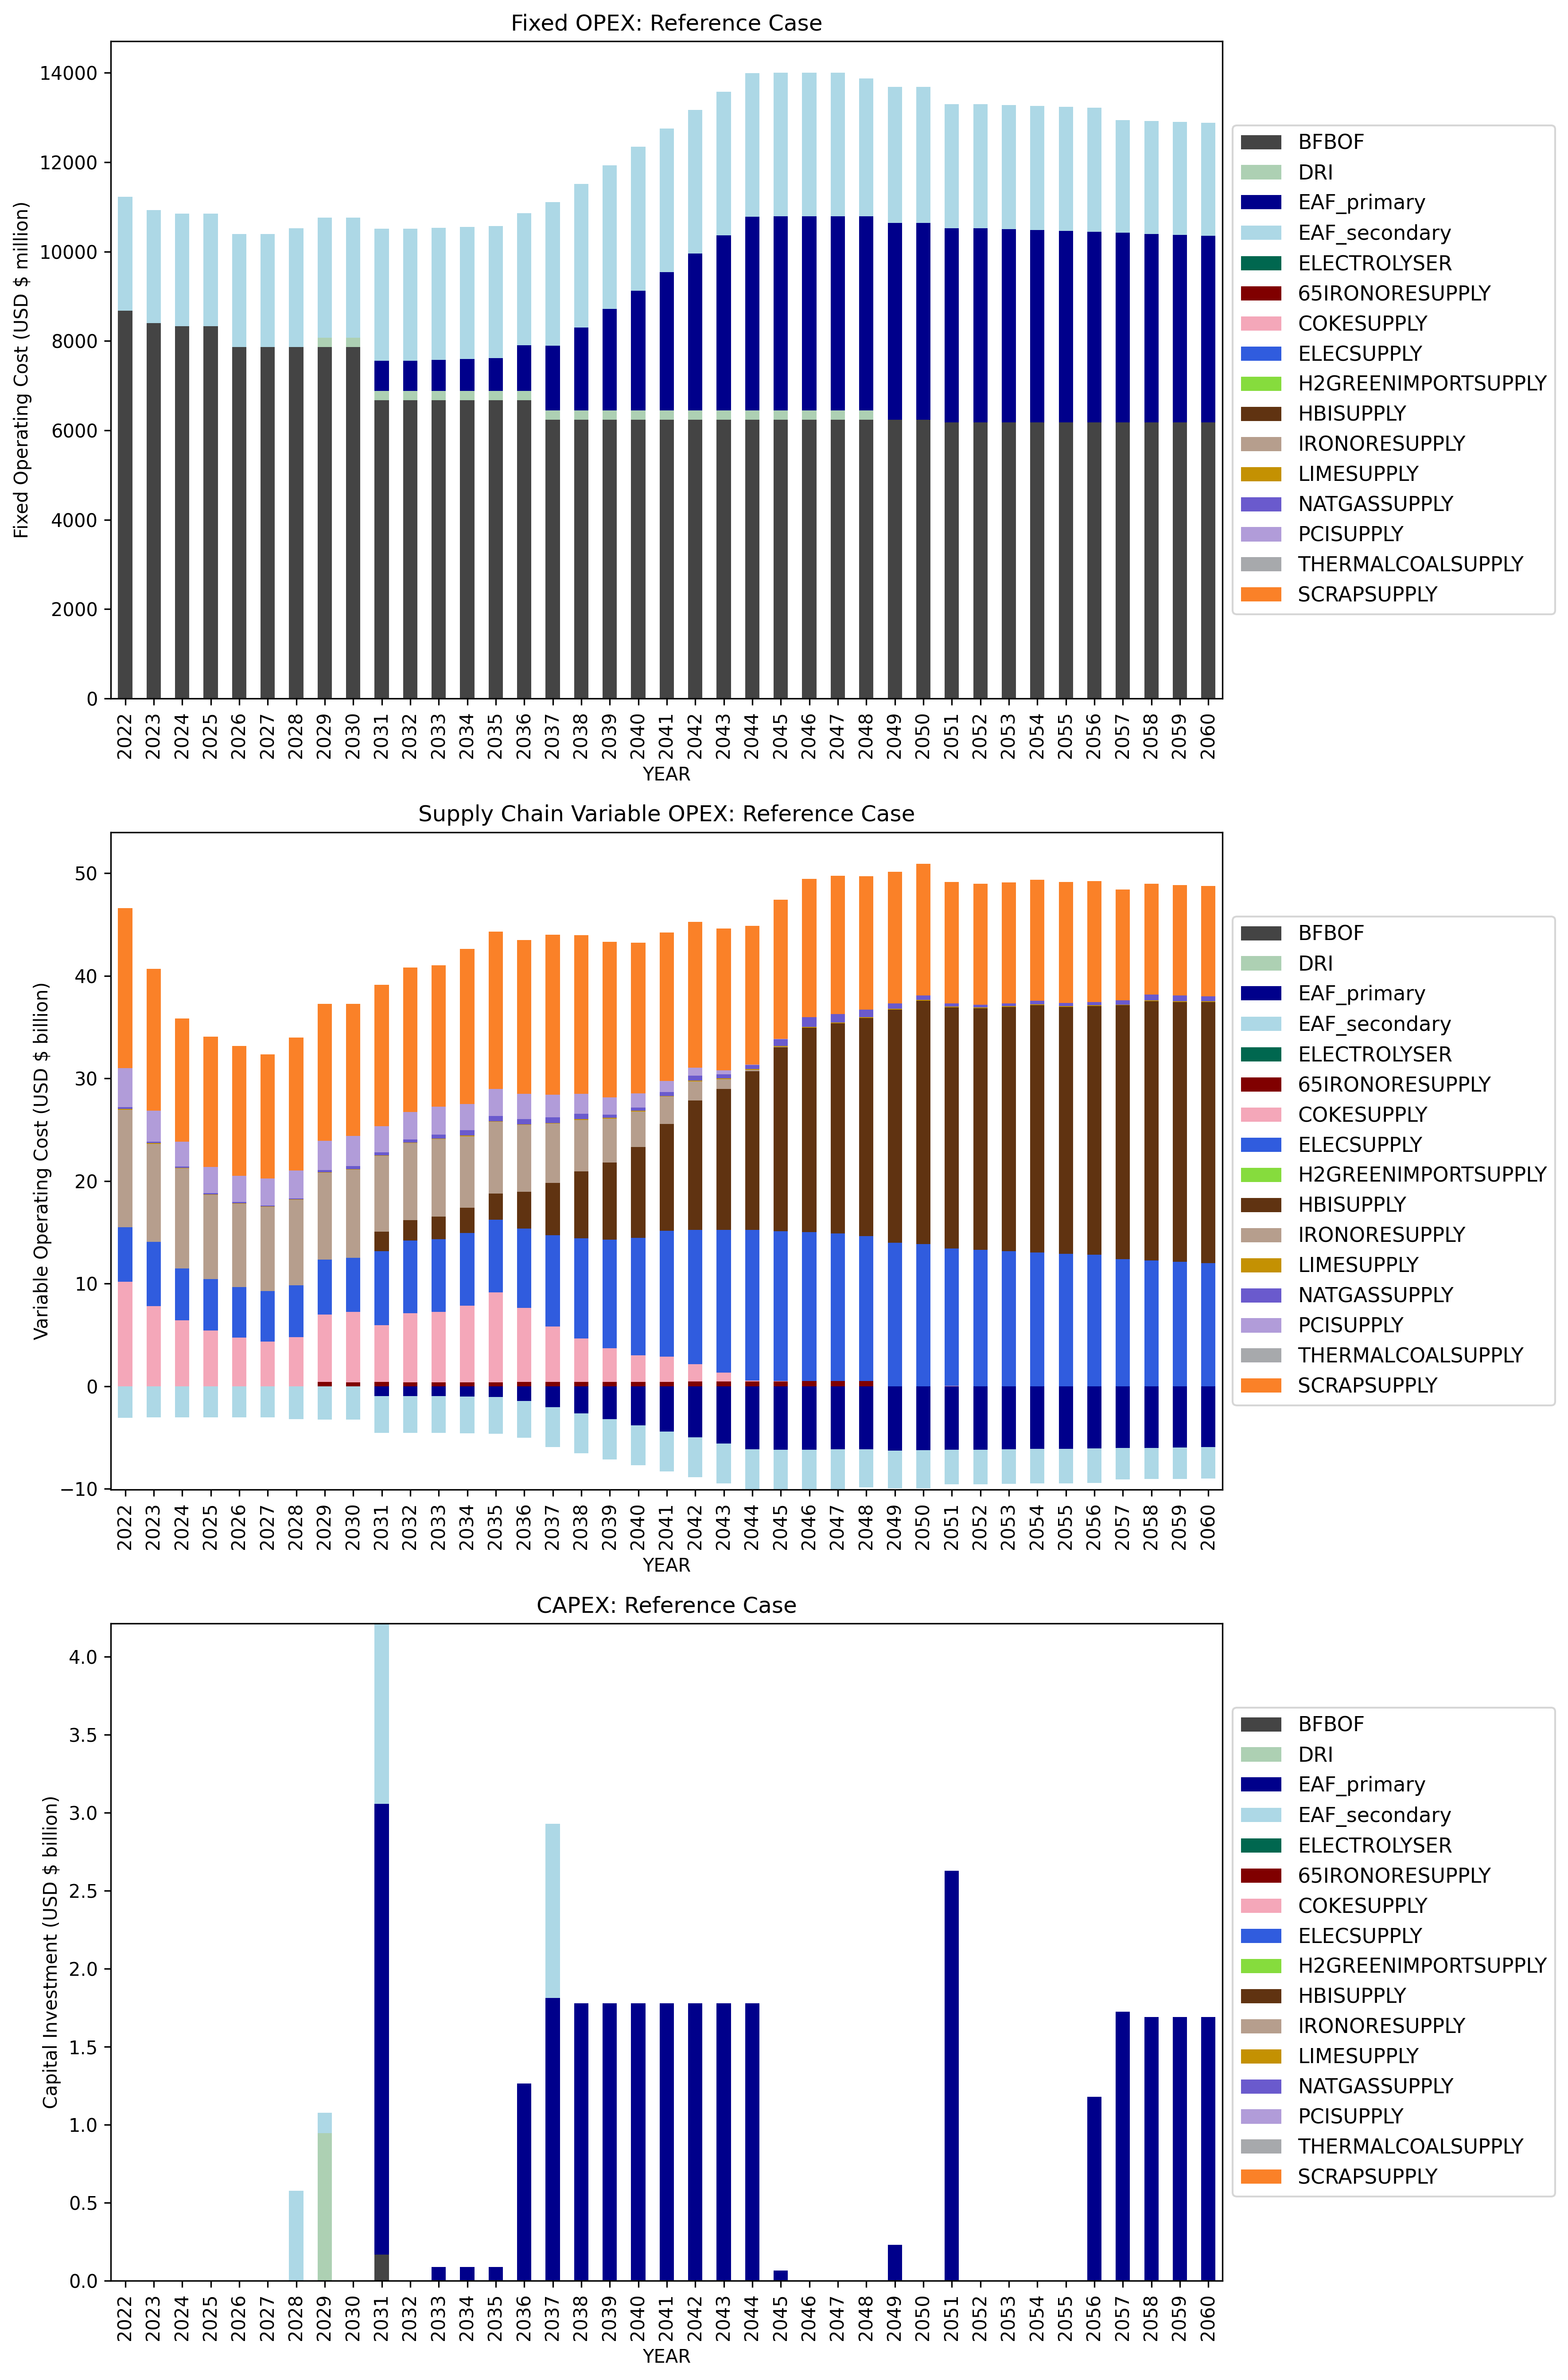

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load DataFrames directly without filtering specific technologies
fixed_operating_cost_df = results['AnnualFixedOperatingCost'].to_dataframe().reset_index()
variable_operating_cost_df = results['AnnualVariableOperatingCost'].to_dataframe().reset_index()
capital_investment_df = results['CapitalInvestment'].to_dataframe().reset_index()
opex_df = results['OperatingCost'].to_dataframe().reset_index()

# Convert the values to USD $ billion or million as needed
fixed_operating_cost_df['AnnualFixedOperatingCost'] = fixed_operating_cost_df['AnnualFixedOperatingCost'] / 1e6
variable_operating_cost_df['AnnualVariableOperatingCost'] = variable_operating_cost_df['AnnualVariableOperatingCost'] / 1e9
capital_investment_df['CapitalInvestment'] = capital_investment_df['CapitalInvestment'] / 1e9
opex_df['OperatingCost'] = opex_df['OperatingCost'] / 1e9

# Define the correct order for technologies in the legend, including the missing ones
ordered_technologies = [
    'BFBOF', 
    'DRI', 
    # 'EAF',
    'EAF_primary', 
    'EAF_secondary', 
    # 'SLABCASTER', 
    'ELECTROLYSER', 
    '65IRONORESUPPLY', 
    # 'BIOMASSSUPPLY', 
    'COKESUPPLY', 
    'ELECSUPPLY', 
    'H2GREENIMPORTSUPPLY', 
    'HBISUPPLY', 
    'IRONORESUPPLY', 
    'LIMESUPPLY', 
    'NATGASSUPPLY', 
    'PCISUPPLY', 
    'THERMALCOALSUPPLY', 
    'SCRAPSUPPLY'
]

# Manually adjust colors for each technology
color_map = {
    'BFBOF': '#444444',  # Dark grey
    'DRI': '#ADD0B3',
    'EAF': '#8DBBCC',    # Blue
    'EAF_primary': 'darkblue',
    'EAF_secondary': 'lightblue',
    # 'SLABCASTER': '#155084',
    'ELECTROLYSER': '#00674F',
    'PCISUPPLY': '#B19CD9',  # Light purple
    'H2GREENIMPORTSUPPLY': '#86DC3D',  # Green
    '65IRONORESUPPLY': '#800000',  # Dark red
    'ELECSUPPLY': '#305CDE',  # Blue
    # 'BIOMASSSUPPLY': '#ED2939',  # Bright red
    'COKESUPPLY': '#F4A7B9',  # Light red/pink
    'THERMALCOALSUPPLY': '#A7A9AC',  # Gray
    'SCRAPSUPPLY': '#FA8128',  # Orange
    'IRONORESUPPLY': '#b69e8d',  # Beige/Brownish
    'HBISUPPLY': '#603311',  # Brown
    'LIMESUPPLY': '#C49102',  # Pastel pink
    'NATGASSUPPLY': '#6A5ACD'  # Light pastel yellow
}

# Pivot the data for plotting
fixed_operating_cost_pivot = fixed_operating_cost_df.pivot(index="YEAR", columns="TECHNOLOGY", values="AnnualFixedOperatingCost").fillna(0)
variable_operating_cost_pivot = variable_operating_cost_df.pivot(index="YEAR", columns="TECHNOLOGY", values="AnnualVariableOperatingCost").fillna(0)
capital_investment_pivot = capital_investment_df.pivot(index="YEAR", columns="TECHNOLOGY", values="CapitalInvestment").fillna(0)

# Create subplots for the three cost types
fig, axes = plt.subplots(3, 1, figsize=(14, 18), dpi=300)  # Adjusted figure size and DPI for better fit

# Plot Fixed Operating Cost
fixed_operating_cost_pivot[ordered_technologies].plot(
    ax=axes[0], kind='bar', stacked=True, 
    color=[color_map[col] for col in ordered_technologies], edgecolor='none'
)
axes[0].set_ylabel("Fixed Operating Cost (USD $ million)")
axes[0].set_title("Fixed OPEX: Reference Case")
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 11})

# Plot Variable Operating Cost
variable_operating_cost_pivot[ordered_technologies].plot(
    ax=axes[1], kind='bar', stacked=True, 
    color=[color_map[col] for col in ordered_technologies], edgecolor='none'
)
axes[1].set_ylabel("Variable Operating Cost (USD $ billion)")
axes[1].set_title("Supply Chain Variable OPEX: Reference Case")
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 11})

# Plot Capital Investment
capital_investment_pivot[ordered_technologies].plot(
    ax=axes[2], kind='bar', stacked=True, 
    color=[color_map[col] for col in ordered_technologies], edgecolor='none'
)
axes[2].set_ylabel("Capital Investment (USD $ billion)")
axes[2].set_title("CAPEX: Reference Case")
axes[2].legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 11})

# Adjust layout to make space for the legends and reduce crowding
plt.tight_layout(rect=[0, 0, 0.85, 1])

# Show the plot
plt.show()


**Levelised cost of steelmaking in $/t-steel**

    YEAR     TotalCost  Production          LCOS
0   2022  1.792302e+12  27462000.0  6.526480e+04
1   2023  1.922014e+13  27248000.0  7.053781e+05
2   2024  4.364970e+10  27216000.0  1.603825e+03
3   2025  4.185843e+10  27216000.0  1.538008e+03
4   2026  4.575309e+13  27216000.0  1.681110e+06
5   2027  4.183968e+13  27216000.0  1.537319e+06
6   2028  3.792925e+13  28661000.0  1.323375e+06
7   2029  4.584632e+10  28986200.0  1.581660e+03
8   2030  4.478264e+10  28986200.0  1.544964e+03
9   2031  4.932419e+10  31876200.0  1.547367e+03
10  2032  4.676874e+10  31876200.0  1.467199e+03
11  2033  4.708656e+10  31876200.0  1.477170e+03
12  2034  4.867247e+10  31876200.0  1.526922e+03
13  2035  5.036012e+10  31876200.0  1.579866e+03
14  2036  5.059365e+10  31876200.0  1.587192e+03
15  2037  5.207922e+10  34665700.0  1.502327e+03
16  2038  5.071747e+10  34665700.0  1.463045e+03
17  2039  4.988006e+10  34665700.0  1.438888e+03
18  2040  4.963509e+10  34665700.0  1.431821e+03
19  2041  5.047198e+

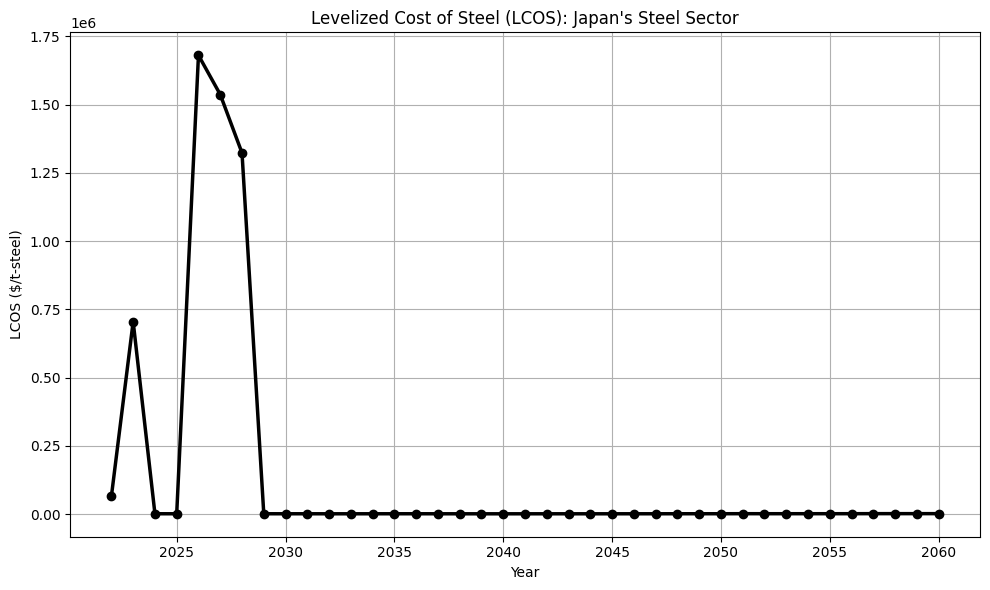

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Load the model and solve it
# my_model = Model.from_yaml("config/japan")
# my_model.solve(log_fn="solver.log")

# # Extract results
# results = my_model.solution

# Extract relevant data
production_df = results['Production'].to_dataframe().reset_index()
operating_cost_df = results['OperatingCost'].to_dataframe().reset_index()
capital_investment_df = results['CapitalInvestment'].to_dataframe().reset_index()

# Filter production data to include only 'CRUDE_STEEL'
steel_production_df = production_df[production_df['FUEL'] == 'SECONDARY_STEEL']

# Sum up steel production for each year
annual_steel_production = steel_production_df.groupby('YEAR')['Production'].sum().reset_index()

# Sum up operating costs for each year
annual_operating_cost = operating_cost_df.groupby('YEAR')['OperatingCost'].sum().reset_index()

# Sum up capital investments for each year
annual_capital_investment = capital_investment_df.groupby('YEAR')['CapitalInvestment'].sum().reset_index()

# Combine costs
annual_total_cost = pd.merge(annual_operating_cost, annual_capital_investment, on='YEAR', how='outer').fillna(0)
annual_total_cost['TotalCost'] = annual_total_cost['OperatingCost'] + annual_total_cost['CapitalInvestment']

# Merge the total costs with steel production
lcos_df = pd.merge(annual_total_cost[['YEAR', 'TotalCost']], annual_steel_production, on='YEAR', how='outer').fillna(0)

# Calculate the LCOS in $/t-steel
lcos_df['LCOS'] = lcos_df['TotalCost'] / lcos_df['Production']

# Display the table
print(lcos_df[['YEAR', 'TotalCost', 'Production', 'LCOS']])

# Save the results to a CSV file
lcos_df.to_csv('LCOS.csv', index=False)

# Plot the LCOS over time
plt.figure(figsize=(10, 6))
plt.plot(lcos_df['YEAR'], lcos_df['LCOS'], linestyle='-', marker='o', color='k', linewidth=2.5)
plt.title("Levelized Cost of Steel (LCOS): Japan's Steel Sector")
plt.xlabel("Year")
#plt.ylim(0, 900)
plt.ylabel("LCOS ($/t-steel)")
plt.grid(True)
plt.tight_layout()
plt.show()


**Capacity Plot**

/var/folders/5w/6cly89qs6hxfqs39wgpz_53h0000gn/T/ipykernel_73497/1490947939.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gross_capacity_filtered['GrossCapacity'] = gross_capacity_filtered['GrossCapacity'] / 1e6
/var/folders/5w/6cly89qs6hxfqs39wgpz_53h0000gn/T/ipykernel_73497/1490947939.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_capacity_filtered['NewCapacity'] = new_capacity_filtered['NewCapacity'] / 1e6
/var/folders/5w/6cly89qs6hxfqs39wgpz_53h0000gn/T/ipykernel_73497/1490947939.py:19:

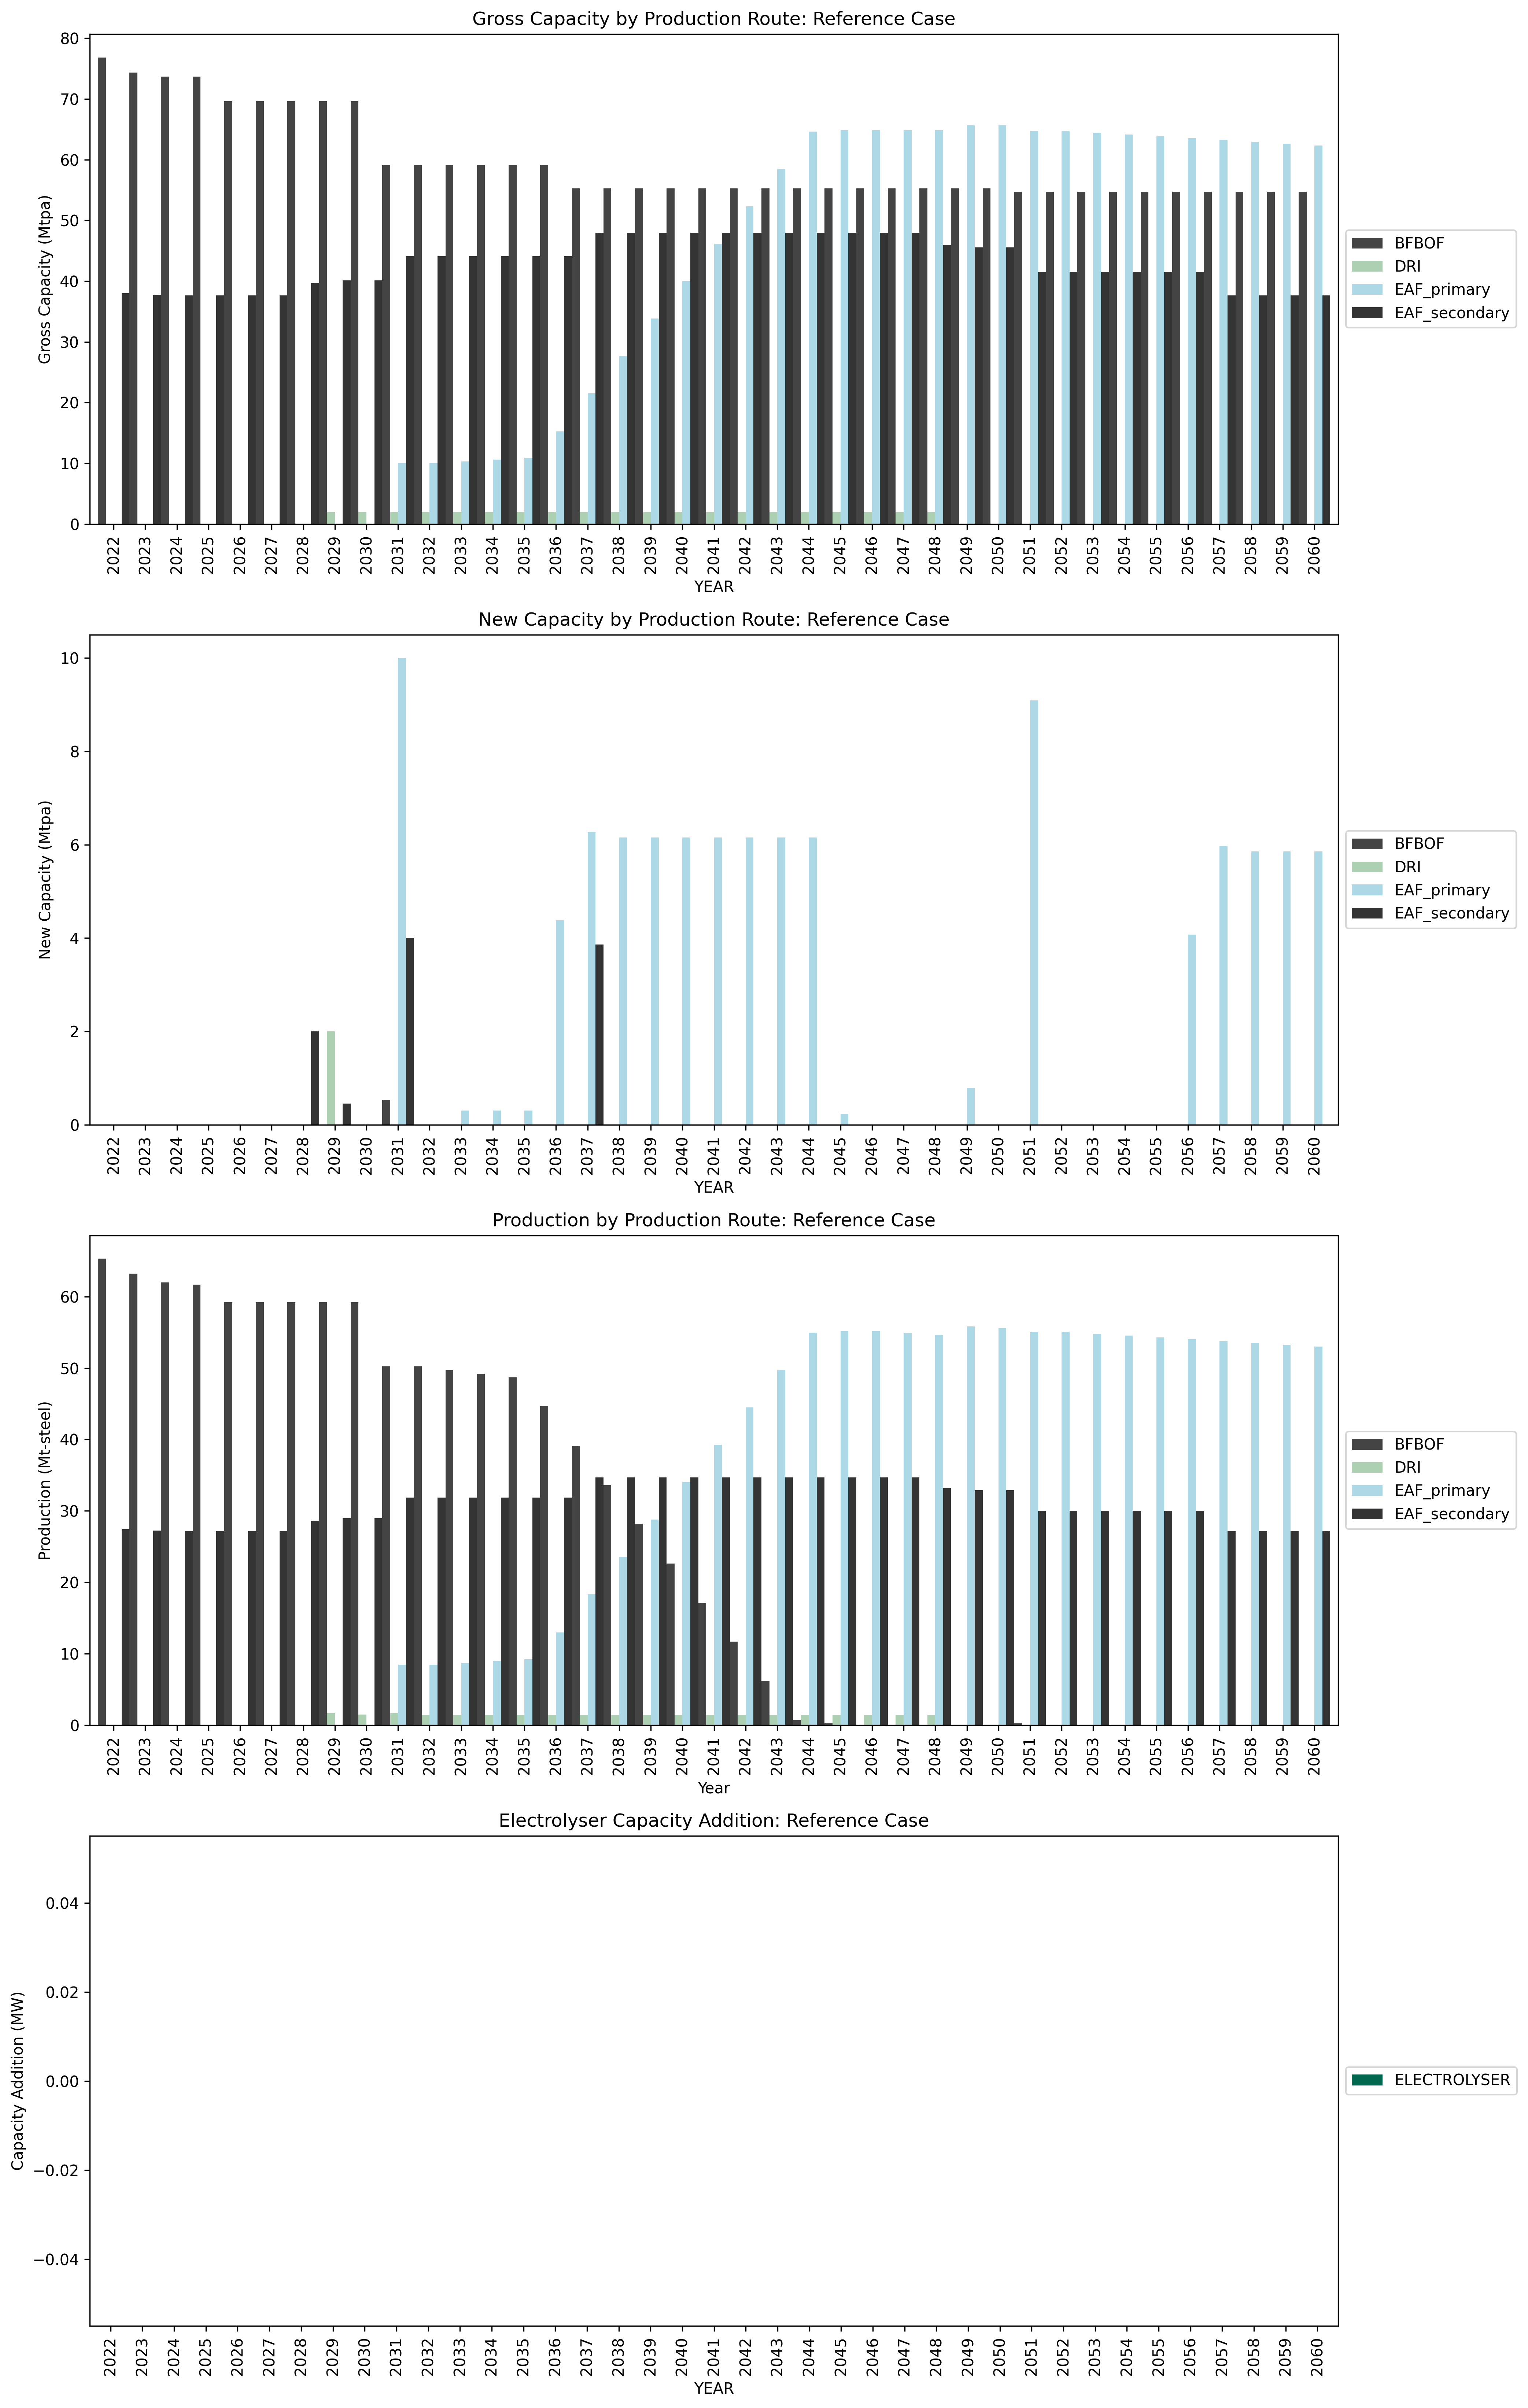

In [ ]:

# Step 3: Convert results to DataFrames
gross_capacity_df = results['GrossCapacity'].to_dataframe().reset_index()
new_capacity_df = results['NewCapacity'].to_dataframe().reset_index()
production_df = results['ProductionByTechnology'].to_dataframe().reset_index()

# Step 4: Include SLABCASTER in the list of production technologies, exclude ELECTROLYSER
production_technologies = ['BFBOF', 'DRI', 'EAF_primary', 'EAF_secondary', 'SLABCASTER']

gross_capacity_filtered = gross_capacity_df[gross_capacity_df['TECHNOLOGY'].isin(production_technologies)]
new_capacity_filtered = new_capacity_df[new_capacity_df['TECHNOLOGY'].isin(production_technologies)]
production_filtered = production_df[production_df['TECHNOLOGY'].isin(production_technologies)]

# Separate the ELECTROLYSER for its own subplot
electrolyser_capacity_filtered = new_capacity_df[new_capacity_df['TECHNOLOGY'] == 'ELECTROLYSER']

# Step 5: Convert relevant data to Mt by dividing by 1e6, except for ELECTROLYSER
gross_capacity_filtered['GrossCapacity'] = gross_capacity_filtered['GrossCapacity'] / 1e6
new_capacity_filtered['NewCapacity'] = new_capacity_filtered['NewCapacity'] / 1e6
production_filtered['ProductionByTechnology'] = production_filtered['ProductionByTechnology'] / 1e6

# Step 6: Pivot the filtered data for plotting
gross_capacity_pivot = gross_capacity_filtered.pivot(index="YEAR", columns="TECHNOLOGY", values="GrossCapacity").fillna(0)
new_capacity_pivot = new_capacity_filtered.pivot(index="YEAR", columns="TECHNOLOGY", values="NewCapacity").fillna(0)
production_pivot = production_filtered.groupby(['YEAR', 'TECHNOLOGY']).sum().reset_index().pivot(index="YEAR", columns="TECHNOLOGY", values="ProductionByTechnology").fillna(0)
electrolyser_capacity_pivot = electrolyser_capacity_filtered.pivot(index="YEAR", columns="TECHNOLOGY", values="NewCapacity").fillna(0)

# Step 7: Define custom colors for the technologies, excluding ELECTROLYSER from the first three plots
color_map = {
    'BFBOF': '#444444',  # Dark grey
    'DRI': '#ADD0B3',    # Light green
    'EAF_primary': '#darkblue',    # Blue
    'EAF_primary': 'lightblue',    # Blue
    'SLABCASTER': '#155084', 
}

# Plotting the data in subplots
fig, axes = plt.subplots(4, 1, figsize=(14, 22), sharex=False, dpi=300)

# Plot Gross Capacity
gross_capacity_pivot.plot(kind="bar", stacked=False, ax=axes[0], color=[color_map.get(col, '#333333') for col in gross_capacity_pivot.columns], width=1)
axes[0].set_ylabel("Gross Capacity (Mtpa)")
axes[0].set_title("Gross Capacity by Production Route: Reference Case")
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Plot New Capacity
new_capacity_pivot.plot(kind="bar", stacked=False, ax=axes[1], color=[color_map.get(col, '#333333') for col in new_capacity_pivot.columns], width=1)
axes[1].set_ylabel("New Capacity (Mtpa)")
axes[1].set_title("New Capacity by Production Route: Reference Case")
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Plot Production by Technology
production_pivot.plot(kind="bar", stacked=False, ax=axes[2], color=[color_map.get(col, '#333333') for col in production_pivot.columns], width=1)
axes[2].set_ylabel("Production (Mt-steel)")
axes[2].set_title("Production by Production Route: Reference Case")
axes[2].set_xlabel("Year")
axes[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Plot Electrolyser Capacity Addition
electrolyser_capacity_pivot.plot(kind="bar", stacked=False, ax=axes[3], color=color_map.get('ELECTROLYSER', '#00674F'), width=0.8)
axes[3].set_ylabel("Capacity Addition (MW)")
axes[3].set_title("Electrolyser Capacity Addition: Reference Case")
axes[3].legend(["ELECTROLYSER"], loc='center left', bbox_to_anchor=(1, 0.5))
# axes[3].set_ylim(0, 1600)


# Adjust layout to make space for titles and labels
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Step 1: Load and solve the model
# my_model = Model.from_yaml("config/japan")
# my_model.solve(log_fn="solver.log")  # This runs the model and outputs the log

# # Step 2: Extract the results
# results = my_model.solution

# # Step 3: Convert results to DataFrames
# new_capacity_df = results['NewCapacity'].to_dataframe().reset_index()

# # Step 4: Filter the DataFrame to include only ELECTROLYSER technology
# electrolyser_capacity_df = new_capacity_df[new_capacity_df['TECHNOLOGY'] == 'ELECTROLYSER']

# # Step 5: Since the capacity should be in MW, ensure the data is already in MW.
# # No need to divide by 1e6 as we're interested in MW, and it's already in this unit

# # Step 6: Pivot the data for easier plotting
# electrolyser_capacity_pivot = electrolyser_capacity_df.pivot(index="YEAR", columns="TECHNOLOGY", values="NewCapacity").fillna(0)

# # Step 7: Plotting the data
# fig, ax = plt.subplots(figsize=(10, 6))

# # Plot New Capacity of Electrolyser in MW
# electrolyser_capacity_pivot.plot(kind="bar", stacked=False, ax=ax, color="blue")
# ax.set_ylabel("New Capacity (MW)")
# ax.set_title("New Capacity of Electrolyser (MW) by Year")
# ax.set_xlabel("Year")

# # Adjust layout to make space for titles and labels
# plt.tight_layout()

# # Show the plot
# plt.show()

**Emissions Plot**

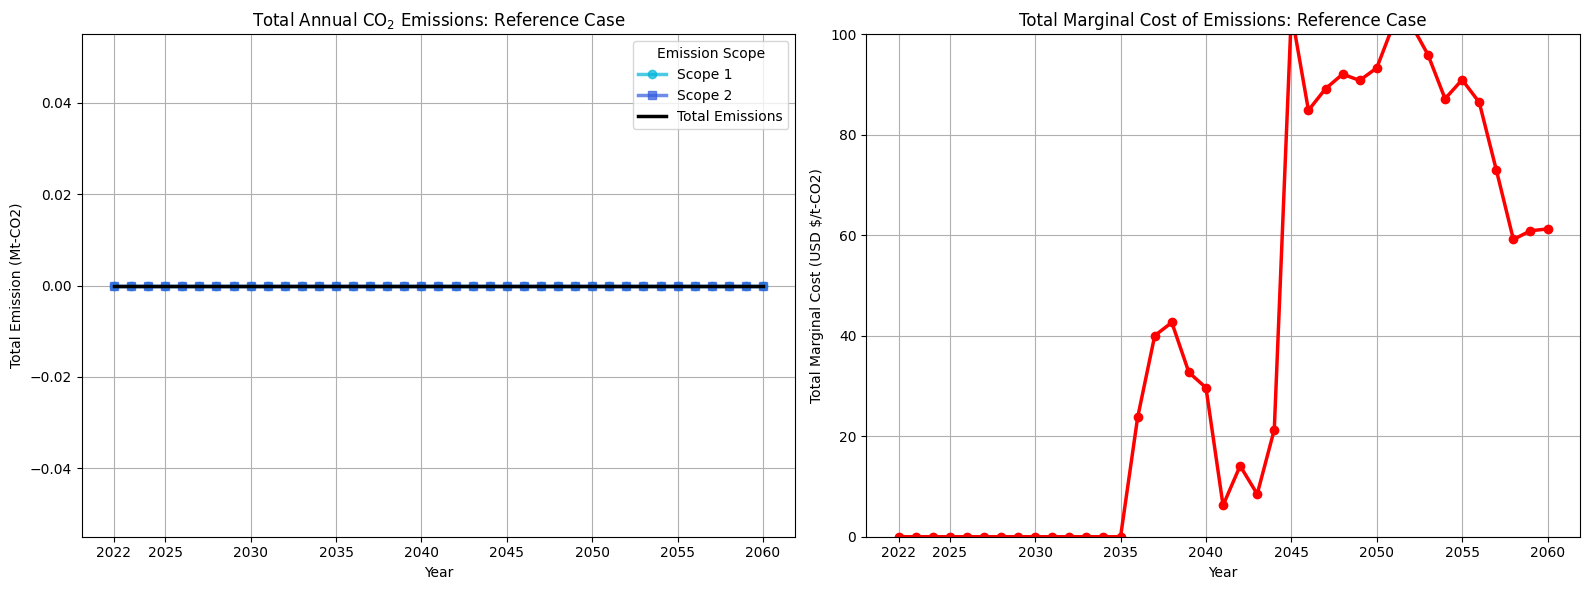

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Load the model and solve it
# my_model = Model.from_yaml("config/japan")
# my_model.solve(log_fn="solver.log")

# # Extract results
# results = my_model.solution

# Extract data for AnnualTechnologyEmission and marginal_cost_of_emissions_annual
emission_data = results['AnnualTechnologyEmission']
marginal_cost_data = results['marginal_cost_of_emissions_annual']

# Convert the xarray data to DataFrames
emission_df = emission_data.to_dataframe().reset_index()
marginal_cost_df = marginal_cost_data.to_dataframe().reset_index()

# Label emissions: Scope 1 for DRI, EAF, BFBOF; Scope 2 for ELECSUPPLY
emission_df['SCOPE'] = emission_df['TECHNOLOGY'].apply(lambda x: 'Scope 1' if x in ['DRI', 'EAF_primary', 'EAF_secondary', 'BFBOF'] else ('Scope 2' if x == 'ELECSUPPLY' else None))

# Filter out rows where SCOPE is None (i.e., technologies not DRI, EAF, BFBOF, or ELECSUPPLY)
filtered_emission_df = emission_df.dropna(subset=['SCOPE'])

# Group the emissions data by YEAR and SCOPE, then sum the emission values
emission_by_scope = filtered_emission_df.groupby(['YEAR', 'SCOPE'])['AnnualTechnologyEmission'].sum().reset_index()

# Divide emissions by 1e6 to convert to MtCO2
emission_by_scope['AnnualTechnologyEmission'] = emission_by_scope['AnnualTechnologyEmission'] / 1e6

# Calculate Total Emissions across all scopes
total_emissions = emission_by_scope.groupby('YEAR')['AnnualTechnologyEmission'].sum().reset_index()
total_emissions['SCOPE'] = 'Total Emissions'

# Fill NaN values with zero
emission_by_scope = emission_by_scope.fillna(0)
marginal_cost_df = marginal_cost_df.fillna(0)

# Group the marginal cost data by YEAR and sum the marginal cost values
total_marginal_cost_per_year = marginal_cost_df.groupby('YEAR')['marginal_cost_of_emissions_annual'].sum().reset_index()

# Convert marginal cost values to absolute values
total_marginal_cost_per_year['marginal_cost_of_emissions_annual'] = total_marginal_cost_per_year['marginal_cost_of_emissions_annual'].abs()

# Merge Total Emissions with emission_by_scope for plotting
emission_by_scope = pd.concat([emission_by_scope, total_emissions])

# Create subplots for the two plots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Emissions by Scope
colors = {'Scope 1': '#00B4DB', 'Scope 2': '#305CDE', 'Total Emissions': 'black'}
markers = {'Scope 1': 'o', 'Scope 2': 's'}

for scope, group in emission_by_scope.groupby('SCOPE'):
    if scope == 'Total Emissions':
        axes[0].plot(group['YEAR'], group['AnnualTechnologyEmission'], linestyle='-',
                     label=scope, color=colors[scope], linewidth=2.5)
    else:
        axes[0].plot(group['YEAR'], group['AnnualTechnologyEmission'], marker=markers[scope], linestyle='-',
                     label=scope, color=colors[scope], linewidth=2.5, alpha=0.7)

axes[0].set_title(r'Total Annual CO$_2$ Emissions: Reference Case')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Total Emission (Mt-CO2)')
axes[0].legend(title="Emission Scope")
axes[0].grid(True)
axes[0].set_xticks([2022, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060])
axes[0].set_xticklabels([2022, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060])  # Ensure the labels are shown

# Plot Total Marginal Cost of Emissions per Year
axes[1].plot(total_marginal_cost_per_year['YEAR'], total_marginal_cost_per_year['marginal_cost_of_emissions_annual'],
             marker='o', linestyle='-', color='red', linewidth=2.5)
axes[1].set_title('Total Marginal Cost of Emissions: Reference Case')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Total Marginal Cost (USD $/t-CO2)')
axes[1].grid(True)
axes[1].set_ylim(0, 100)
axes[1].set_xticks([2022, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060])
axes[1].set_xticklabels([2022, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060])  # Ensure the labels are shown

# Adjust layout and show plot
plt.tight_layout()
plt.show()


**Activity by Supply Technologies**

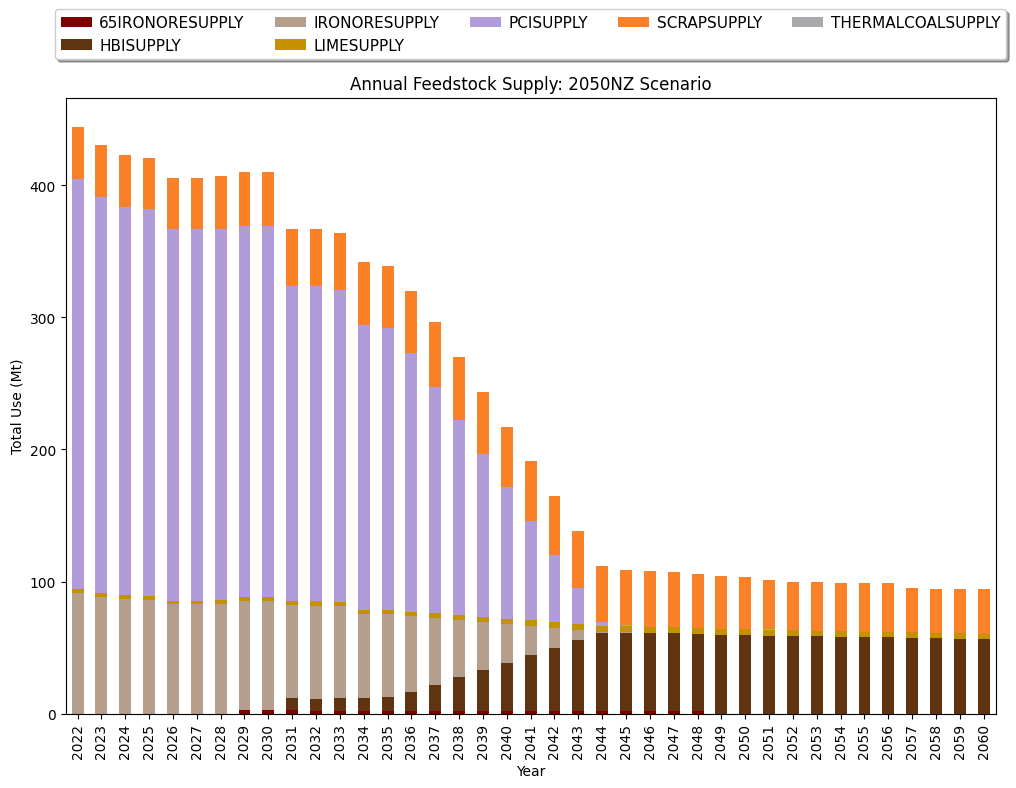

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Load the model and solve it
# my_model = Model.from_yaml("config/japan")
# my_model.solve(log_fn="solver.log")

# # Extract results
# results = my_model.solution

# Convert TotalAnnualTechnologyActivityByMode to DataFrame and reset index
activity_df = results['TotalAnnualTechnologyActivityByMode'].to_dataframe().reset_index()

# List of feedstock supply technologies
feedstock_technologies = [
    'LIMESUPPLY', 'IRONORESUPPLY', 'SCRAPSUPPLY', 'PCISUPPLY',
    'THERMALCOALSUPPLY', '65IRONORESUPPLY', 'HBISUPPLY'
]

# Filter the DataFrame to include only feedstock supply technologies
feedstock_activity_df = activity_df[activity_df['TECHNOLOGY'].isin(feedstock_technologies)]

# Group by YEAR, REGION, TECHNOLOGY, and sum the values
grouped_feedstock_activity_df = feedstock_activity_df.groupby(['YEAR', 'TECHNOLOGY']).sum().reset_index()

# Pivot the data for plotting
pivot_feedstock_activity_df = grouped_feedstock_activity_df.pivot(index="YEAR", columns="TECHNOLOGY", values="TotalAnnualTechnologyActivityByMode")

# Convert the values to Mt by dividing by 1e6
pivot_feedstock_activity_df = pivot_feedstock_activity_df.apply(lambda x: x / 1e6)

# Ensure all values are numeric and fill NaN with 0
pivot_feedstock_activity_df = pivot_feedstock_activity_df.apply(pd.to_numeric, errors='coerce').fillna(0)

# Define the color map with correct color assignments
color_map = {
    'BFBOF': '#444444',  # Dark grey
    'DRI': '#ADD0B3',
    'EAF': '#8DBBCC',    # Blue
    'SLABCASTER': '#155084',
    'ELECTROLYSER': '#00674F',
    'PCISUPPLY': '#B19CD9',  # Light purple
    'H2GREENIMPORTSUPPLY': '#86DC3D',  # Green
    '65IRONORESUPPLY': '#800000',  # Dark red
    'ELECSUPPLY': '#305CDE',  # Blue
    'BIOMASSSUPPLY': '#ED2939',  # Bright red
    'COKESUPPLY': '#F4A7B9',  # Light red/pink
    'THERMALCOALSUPPLY': '#A7A9AC',  # Gray
    'SCRAPSUPPLY': '#FA8128',  # Orange
    'IRONORESUPPLY': '#b69e8d',  # Beige/Brownish
    'HBISUPPLY': '#603311',  # Brown
    'LIMESUPPLY': '#C49102',  # Pastel pink
    'NATGASSUPPLY': '#6A5ACD'  # Light pastel yellow
}

# Extract the technologies that are actually present in the pivot table
present_technologies = pivot_feedstock_activity_df.columns.tolist()

# Generate the colors dynamically based on the present technologies
colors = [color_map[tech] for tech in present_technologies]

# Plot the data
pivot_feedstock_activity_df.plot(
    kind="bar", stacked=True, color=colors, figsize=(12, 8),edgecolor='none'
)

# Set the labels and title
plt.xlabel("Year")
plt.ylabel("Total Use (Mt)")
plt.title("Annual Feedstock Supply: 2050NZ Scenario")

# Customize the legend to match the colors with the correct labels
plt.legend(
    present_technologies, loc='lower center', bbox_to_anchor=(0.5, 1.05),
    fancybox=True, shadow=True, ncol=5, prop={'size': 11},
    handletextpad=0.5, labelspacing=0.5
)

# Show the plot
plt.show()


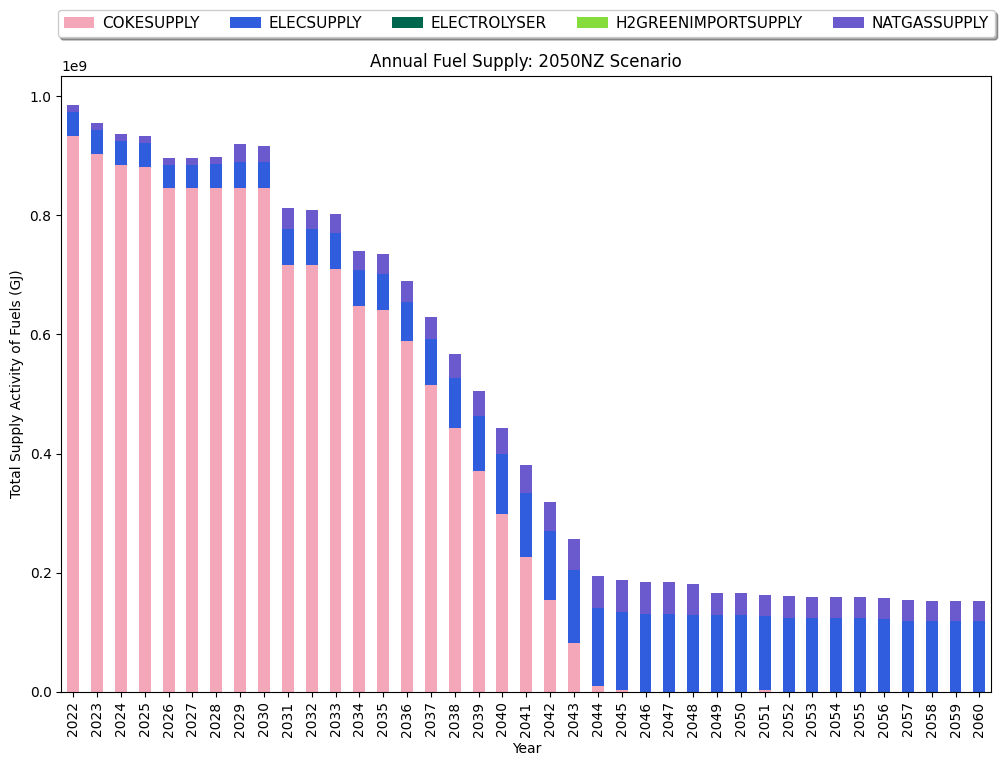

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from tz.osemosys import Model

# # Load the model and solve it
# my_model = Model.from_yaml("config/japan")
# my_model.solve(log_fn="solver.log")

# # Extract results
# results = my_model.solution

# Convert TotalAnnualTechnologyActivityByMode to DataFrame and reset index
activity_df = results['TotalAnnualTechnologyActivityByMode'].to_dataframe().reset_index()

# List of supply technologies
supply_technologies = [
    'COKESUPPLY', 'NATGASSUPPLY', 'ELECSUPPLY', 'BIOMASSSUPPLY',
    'H2GREENIMPORTSUPPLY', 'ELECTROLYSER'
]

# Filter the DataFrame to include only supply technologies
supply_activity_df = activity_df[activity_df['TECHNOLOGY'].isin(supply_technologies)]

# Group by YEAR, REGION, TECHNOLOGY, and sum the values
grouped_supply_activity_df = supply_activity_df.groupby(['YEAR', 'TECHNOLOGY']).sum().reset_index()

# Pivot the data for plotting
pivot_supply_activity_df = grouped_supply_activity_df.pivot(index="YEAR", columns="TECHNOLOGY", values="TotalAnnualTechnologyActivityByMode")

# Ensure all values are numeric and fill NaN with 0
pivot_supply_activity_df = pivot_supply_activity_df.apply(pd.to_numeric, errors='coerce').fillna(0)

# Define the custom color map specifically for supply technologies
color_map = {
    'COKESUPPLY': '#F4A7B9',  # Light red/pink
    'NATGASSUPPLY': '#6A5ACD',  # Light purple blue
    'ELECSUPPLY': '#305CDE',  # Blue
    'BIOMASSSUPPLY': '#ED2939',  # Bright red
    'H2GREENIMPORTSUPPLY': '#86DC3D',  # Green
    'ELECTROLYSER': '#00674F',  # Dark green
}

# Plot the data using the custom color map
colors = [color_map[tech] for tech in pivot_supply_activity_df.columns]
pivot_supply_activity_df.plot(kind="bar", stacked=True, color=colors, figsize=(12, 8), edgecolor='none')

# Set the labels and title
plt.xlabel("Year")
plt.ylabel("Total Supply Activity of Fuels (GJ)")
plt.title("Annual Fuel Supply: 2050NZ Scenario")

# Customize the legend
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), fancybox=True, shadow=True, ncol=5, prop={'size': 11}, handletextpad=0.5, labelspacing=0.5)

# Show the plot
plt.show()


**Everything Else**

In [ ]:
# ##Try to see all output variables in one go - failed - some graphs should be filtered by Operating mode too! Act as a visual reference onlyu
# import pandas as pd
# import matplotlib.pyplot as plt
# from tz.osemosys import Model

# # Load the model and solve it
# my_model = Model.from_yaml("config/japan")
# my_model.solve(log_fn="solver.log")

# # Extract results for the various variables
# results = my_model.solution

# # Define a function to plot variables
# def plot_variable(ax, data, title):
#     df = data.to_dataframe().reset_index()
#     if 'YEAR' in df.columns:
#         grouped_df = df.groupby('YEAR').sum(numeric_only=True).reset_index()
#         ax.plot(grouped_df['YEAR'], grouped_df[grouped_df.columns[1]], marker='o', linestyle='-')
#         ax.set_title(title, fontsize=10)
#         ax.set_xlabel('Year', fontsize=8)
#         ax.set_ylabel('Value', fontsize=8)
#         ax.tick_params(axis='both', which='major', labelsize=8)
#         ax.grid(True)

# # Create a figure with a 5x6 grid of subplots
# fig, axs = plt.subplots(5, 6, figsize=(24, 20))
# fig.suptitle('Model Outputs', fontsize=16)

# # List of variables to plot
# variables = [
#     ('AnnualFixedOperatingCost', 'Annual Fixed Operating Cost'),
#     ('AnnualTechnologyEmission', 'Annual Technology Emission'),
#     ('AnnualVariableOperatingCost', 'Annual Variable Operating Cost'),
#     ('CapitalInvestment', 'Capital Investment'),
#     ('DiscountedCapitalInvestment', 'Discounted Capital Investment'),
#     ('DiscountedOperatingCost', 'Discounted Operating Cost'),
#     ('DiscountedSalvageValue', 'Discounted Salvage Value'),
#     ('GrossCapacity', 'Gross Capacity'),
#     ('NewCapacity', 'New Capacity'),
#     ('DemandNeedingReserveMargin', 'Demand Needing Reserve Margin'),
#     ('DiscountedCapitalInvestment', 'Discounted Capital Investment'),
#     ('DiscountedOperatingCost', 'Discounted Operating Cost'),
#     ('DiscountedSalvageValue', 'Discounted Salvage Value'),
#     ('GrossCapacity', 'Gross Capacity'),
#     ('NewCapacity', 'New Capacity'),
#     ('NumberOfNewTechnologyUnits', 'Number Of New Technology Units'),
#     ('OperatingCost', 'Operating Cost'),
#     ('Production', 'Production'),
#     ('ProductionByTechnology', 'Production By Technology'),
#     ('SalvageValue', 'Salvage Value'),
#     ('TotalAnnualTechnologyActivityByMode', 'Total Annual Technology Activity By Mode'),
#     ('TotalCapacityInReserveMargin', 'Total Capacity In Reserve Margin'),
#     ('TotalDiscountedCost', 'Total Discounted Cost'),
#     ('TotalDiscountedCostByTechnology', 'Total Discounted Cost By Technology'),
#     ('TotalTechnologyAnnualActivity', 'Total Technology Annual Activity'),
#     ('TotalTechnologyModelPeriodActivity', 'Total Technology Model Period Activity'),
#     ('Use', 'Use'),
#     ('marginal_cost_of_demand', 'Marginal Cost Of Demand'),
#     ('marginal_cost_of_demand_annual', 'Marginal Cost Of Demand Annual'),
#     ('marginal_cost_of_emissions_annual', 'Marginal Cost Of Emissions Annual'),
#     ('marginal_cost_of_emissions_total', 'Marginal Cost Of Emissions Total')
# ]

# # Plot each variable in the grid
# for ax, (var, title) in zip(axs.flat, variables):
#     if var in results:
#         data = results[var]
#         plot_variable(ax, data, title)

# # Remove any empty subplots
# for ax in axs.flat[len(variables):]:
#     fig.delaxes(ax)

# # Adjust layout and show the plot
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.show()
